# Regresija

Regresiona analiza je jedna od najvaznijih polja u statistici i masinskom ucenju.

Regresija trazi zavisnosti medju varijablama.

Primer: Mozemo gledati zaposlene jedne kompanije i pokusati da razumemo kako
njihova plata zavisi od njihovih `osobina`, kao sto su iskustvo, stepen obrazovanja, uloga, i tako dalje.. 

Ovo je regresioni problem gde podaci za svakog zaposlenog predstavljaju jednu `opservaciju`.
Pretpostavka je da su gore-navedene `osobine` nezavisne.

U sustini, nas zadatak je da nadjemo funkciju koja povezuje `osobine` sa `osobinama` na dovoljno precizan nacin.

Zavisne `osobine` nazivamo `odgovorima`
Nezavisno `osobine` nazivamo `regresorima`

Simbolicka regresija je tehnika masinskog ucenja koja pokusava da identifikuje matematicki izraz koji najbolje opisuje vezu izmedju `odgovora` i `regresora` u cilju da predvidi nove ishode. 

Nas pristup ce biti genetski, gde ce svaka generacija zadrzati potomke koji su se najbolje pokazali i koristiti ih u buducim mutacijama.

Modeli masinskog ucenja su trenutno alatke koje se najpre koriste da otkriju zakone fizike. Iako pokazuju obecavajuce rezultate u otkrivanju fizickih osobina materijala, tipicni parametrizovani modeli koji su se do sada izvanredno pokazali u nagadjanju broja zarazenih za vreme globalne pandemije, ne mogu objasniti brojke do kojih su dosli, zbog cega je stepen njihove korisnosti ogranicen.

U ovom projektu, fokusiracemo se na alternativu za modele masinskog ucenja - **Simbolicku regresiju (SR)**


## Simbolicka Regresija
Simbolicka regresija u isto vreme trazi optimalnu formu funkcije i skup regresora za dati problem, i poprilicno je korisna tehnika regresije kada je malo poznato o samoj strukturi i distribuciji podataka za unos.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Generacija inicijalnog skupa podataka
Rezultat ove funkcije je kombinacija linearnog $x$, $sin{x}$, $x^3$

Oblik krive i uvelicana slika jednog njegovog segmenta ce biti prikazane ispod

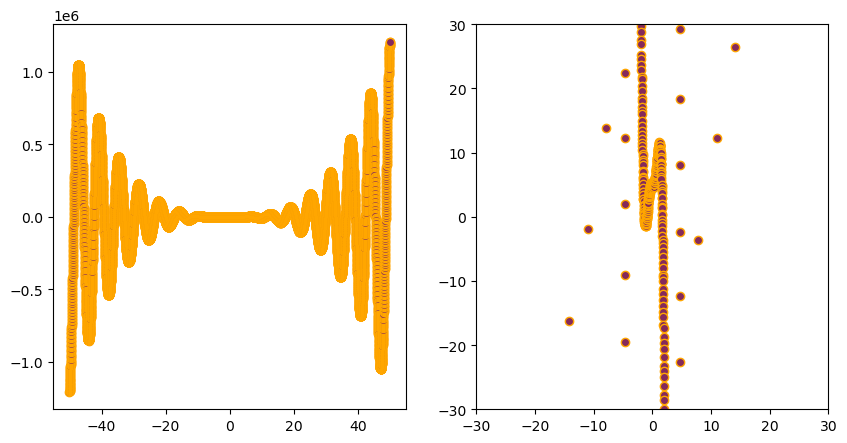

In [2]:
nsample = 10000
sig = 0.2
x = np.linspace(-50, 50, nsample)
X = np.column_stack((x/5 * np.sin(x), 10*x*(np.cos(x)*x**2), x*np.cos(x), np.ones(nsample)))
beta = [0.01, 1, 0.001, 5.]
y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)
df = pd.DataFrame()
df['x']=x
df['y']=y


point_color = '#852a5b'
edgecolorsA = '#ffa600'
edgecolorsB = '#73fffa'

fig, (ax1, ax2) = plt.subplots(1,  2, figsize=(10,  5))

ax1.scatter(df['x'], df['y'], c=point_color, edgecolors=edgecolorsA, alpha=1.0)
ax2.scatter(df['x'], df['y'], c=point_color, edgecolors=edgecolorsA, alpha=1.0)
plt.xlim(-30, 30)
plt.ylim(-30,  30)

plt.show()

In [3]:
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *

## Razdvajanje skupa podataka

Kako cemo testirati razlicite pristupe ovom problemu, moramo razdeliti skup podataka na skup za treniranje i skup za testiranje



In [4]:
from sklearn.model_selection import train_test_split
X = df[['x']]
y = df['y']
y_true = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [5]:
X_test

,x
6252,12.526253
4684,-3.155316
1731,-32.688269
4742,-2.575258
4521,-4.785479
...,...
8014,30.148015
1074,-39.258926
3063,-19.366937
6487,14.876488


In [6]:
function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg','inv']
est_gp = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=45, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                          feature_names=X_train.columns)

In [7]:
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}

In [8]:
est_gp.fit(X_train, y_train)
print('R2:',est_gp.score(X_test,y_test))
next_e = sympify(str(est_gp._program), locals=converter)
next_e

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.94           199891        6           193747           230638      4.66m
   1    15.59           197995        3           193568           232248      4.45m
   2    15.10           197444       16           193715           230921      4.19m
   3    14.56           197516        3           193832           229871      4.00m
   4    14.34           197716       13           193500           232856      3.91m
   5    14.25           197728       23           193156           235969      3.74m
   6    13.59           197463        3           193216           235414      3.62m
   7    14.07           198473       18           193271           234924      3.61m
   8    14.31           198860        3           193407           233694  

9.98005057384905*x**2*(x + sin(1/(x + sin(1/x))))*cos(x) + (x - sin(8.38530858294228*x**2/sin(1/x)))*cos(x) + sin(0.883598336878722*x + 0.883598336878722*sin(1/x)) + 0.389

In [9]:
est_tree = DecisionTreeRegressor(max_depth=5)
est_tree.fit(X_train, y_train)
est_rf = RandomForestRegressor(n_estimators=100,max_depth=5)
est_rf.fit(X_train, y_train)
y_gp = est_gp.predict(X_test)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(X_test)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(X_test)
score_rf = est_rf.score(X_test, y_test)

In [10]:
print('score_gp: ' + str(score_gp),
'score_tree: ' + str(score_tree),
'score_rf: ' + str(score_rf),
sep='\n'
)

score_gp: 0.9999998332363309
score_tree: 0.4933379510226419
score_rf: 0.58824076850755


<Figure size 640x480 with 0 Axes>

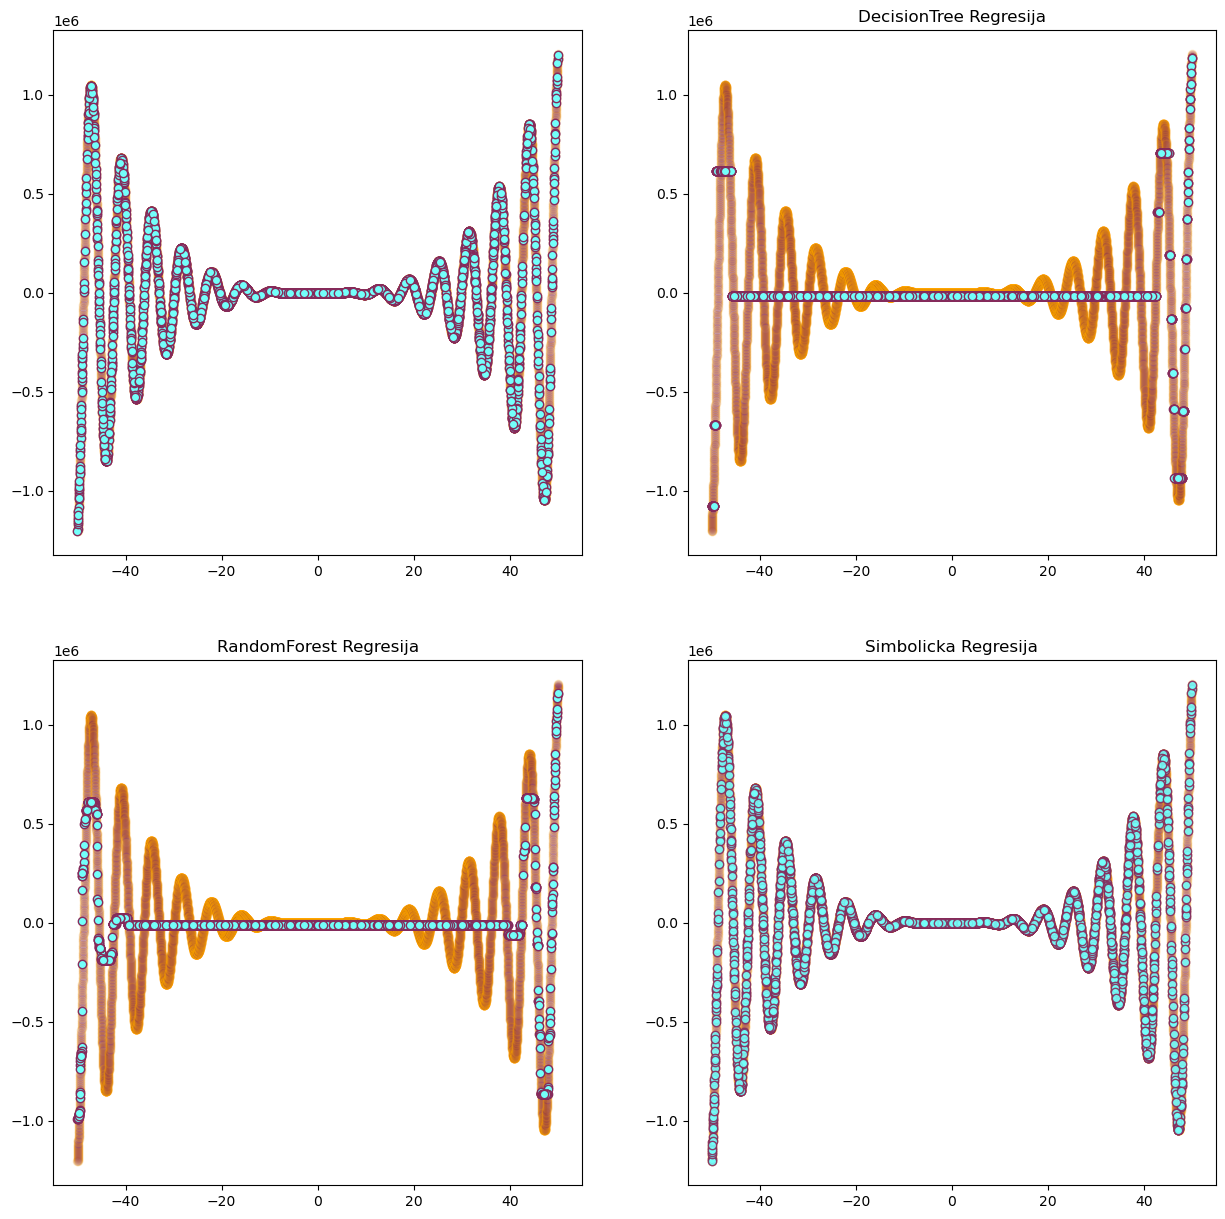

In [11]:
plt.clf()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,  2, figsize=(15,  15))


ax1.scatter(X, y_true, c=point_color, edgecolors=edgecolorsA, alpha=0.2)
ax1.scatter(X_test, y_test, c=edgecolorsB, edgecolors=point_color, alpha=1.0)

ax2.set_title("DecisionTree Regresija")
ax2.scatter(X, y_true, c=point_color, edgecolors=edgecolorsA, alpha=0.2)
ax2.scatter(X_test, y_tree, c=edgecolorsB, edgecolors=point_color, alpha=1.0)

ax3.set_title("RandomForest Regresija")
ax3.scatter(X, y_true, c=point_color, edgecolors=edgecolorsA, alpha=0.2)
ax3.scatter(X_test, y_rf, c=edgecolorsB, edgecolors=point_color, alpha=1.0)

ax4.set_title("Simbolicka Regresija")
ax4.scatter(X, y_true, c=point_color, edgecolors=edgecolorsA, alpha=0.2)
ax4.scatter(X_test, y_gp, c=edgecolorsB, edgecolors=point_color, alpha=0.9)

plt.show()

Na plotovima iznad mozemo primetiti da iako rezultati nisu izvanredno dobri u poredjenju sa drugim tehnikama, nasa analiticka funkcija se mnogo bolje pokazala u sredisnjim segmentima.

In [ ]:
from gplearn.functions import make_function

def pow_3(x1):
    f = x1**3
    return f

pow_3 = make_function(function=pow_3,name='pow3',arity=1)

function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg','inv', pow_3]

est_gp = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=45, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                           feature_names=X_train.columns)
est_gp.fit(X_train, y_train)
print('R2:',est_gp.score(X_test,y_test))
next_e = sympify(str(est_gp._program), locals=converter)
next_e

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    14.13      2.88051e+61       31           177125           196942      5.33m
   1    13.14      1.29469e+42       23           176838           185381      4.86m
   2    15.01     6.29798e+154       32          77012.6          76413.2      5.48m


In [ ]:
est_tree = DecisionTreeRegressor(max_depth=5)
est_tree.fit(X_train, y_train)
est_rf = RandomForestRegressor(n_estimators=100,max_depth=5)
est_rf.fit(X_train, y_train)
y_gp = est_gp.predict(X_test)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(X_test)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(X_test)
score_rf = est_rf.score(X_test, y_test)

In [ ]:
print('score_gp: ' + str(score_gp),
'score_tree: ' + str(score_tree),
'score_rf: ' + str(score_rf),
sep='\n'
)

In [ ]:
plt.clf()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,  2, figsize=(15,  15))


ax1.scatter(X, y_true, c=point_color, edgecolors=edgecolorsA, alpha=0.2)
ax1.scatter(X_test, y_test, c=edgecolorsB, edgecolors=point_color, alpha=1.0)

ax2.set_title("DecisionTree Regresija")
ax2.scatter(X, y_true, c=point_color, edgecolors=edgecolorsA, alpha=0.2)
ax2.scatter(X_test, y_tree, c=edgecolorsB, edgecolors=point_color, alpha=1.0)

ax3.set_title("RandomForest Regresija")
ax3.scatter(X, y_true, c=point_color, edgecolors=edgecolorsA, alpha=0.2)
ax3.scatter(X_test, y_rf, c=edgecolorsB, edgecolors=point_color, alpha=1.0)

ax4.set_title("Simbolicka Regresija")
ax4.scatter(X, y_true, c=point_color, edgecolors=edgecolorsA, alpha=0.2)
ax4.scatter(X_test, y_gp, c=edgecolorsB, edgecolors=point_color, alpha=0.9)

plt.show()

Ukoliko bismo uporedili trenutni i prosli plot za **SR**, primetili bismo da je model mnogo pouzdaniji, a dokaz za to mozemo videti u R2 metrikama. Time sto smo rucno dodali funkciju u listu funkcija koje se koriste u svrhe simbolicke regresije, uprostili smo model - cime smo najpre sprecili overfitting.

# Kombinovanje **GridSearchCV** sa **SR**

GridSearchCV odredjuje najbolje parametre tako sto vrsi pretragu
kroz mrezu hiperparametara za dati model i optimizuje model masinskog ucenja tako sto trenira i evaluira model za svaku kombinaciju hiperparametara koristeci medju-validaciju. Poprilicno je rasprostranjene upotrebe. Takodje cemo u koraku pretprocesiranja standardizovati podatke koristeci StandardScaler iz sklearn biblioteke. 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from gplearn.genetic import SymbolicRegressor

In [ ]:
from gplearn.functions import make_function
from sklearn.model_selection import GridSearchCV
def pow_3(x1):
    f = x1**3
    return f

pow_3 = make_function(function=pow_3,name='pow3',arity=1)

function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg','inv', pow_3]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=45, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                           feature_names=X_train.columns))
])

param_grid = {
    'regressor__generations': [35,  45,  55],
    'regressor__p_crossover': [0.7,  0.8,  0.9],
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, refit=True)
grid_search.fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_)
print('R2:', grid_search.score(X_test, y_test))

pipeline.fit(X_train, y_train)
print('R2:',pipeline.score(X_test,y_test))
